In [1]:
# All data are inside data folder
# Before running this notebook, please unzip all zipped data under data/parking-tickets folder.
# Data had to be zipped as their size were more than 100 MB and github does not allow to upload 100 MB files.
# It is important to note that encoding format of existing parking-tickets at https://open.toronto.ca are not same
# For example, for 2008 and 2010 infraction data encoding format was utf-16le while all other data encoding format was utf-8
# The encoding format for few of data has been changed such that all data at github is saved in utf-8 format 
# so, it is important to run this notebook file with data available at github along with this file. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import glob
import geopandas as gpd

In [3]:
def season_of_date(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Fall'

In [4]:
df_infractions_by_frequency = pd.DataFrame()
df_infractions_by_revenue = pd.DataFrame()
infractions_count_per_week_day = pd.DataFrame()
infractions_count_per_month = pd.DataFrame()
infractions_count_per_season = pd.DataFrame()
infractions_count_per_year = pd.DataFrame()

all_files = glob.glob("data/parking-tickets/*/*")
for file in all_files:
    df = pd.read_csv(filepath_or_buffer=file, 
                            encoding='utf-8', # some of input file are using utf-16le encode, so saved all with utf-8
                            error_bad_lines=False,
                            engine = 'python', # python engine needed to take care EOF file problem with data
                            keep_default_na = False, # to drop float NaN(at the place of missing values), which convert infraction code to float number instead of integer 
                            usecols = ['infraction_code', 'set_fine_amount', 'date_of_infraction', 'location2'])
    df_infractions_by_frequency_new = df.groupby('infraction_code')['infraction_code'].count().reset_index(name ='frequency')
    df_infractions_by_frequency = pd.concat([df_infractions_by_frequency, df_infractions_by_frequency_new])
    
    df_infractions_by_revenue_new = df.groupby('infraction_code')['set_fine_amount'].sum().reset_index(name ='fine_amount')
    df_infractions_by_revenue = pd.concat([df_infractions_by_revenue, df_infractions_by_revenue_new])
    
    df['date_of_infraction'] = pd.to_datetime(df['date_of_infraction'], format='%Y%m%d', errors='coerce')
    
    df['week_day'] = df['date_of_infraction'].dt.day_name()
    infractions_count_per_week_day_new = df.groupby('week_day')['week_day'].count().reset_index(name ='frequency')
    infractions_count_per_week_day = pd.concat([infractions_count_per_week_day, infractions_count_per_week_day_new], sort=False)

    df['month'] = df['date_of_infraction'].dt.month_name()
    infractions_count_per_month_new = df.groupby('month')['month'].count().reset_index(name ='frequency')
    infractions_count_per_month = pd.concat([infractions_count_per_month, infractions_count_per_month_new], sort=False)

    df['year'] = df['date_of_infraction'].dt.year
    infractions_count_per_year_new = df.groupby('year')['year'].count().reset_index(name ='frequency')
    infractions_count_per_year = pd.concat([infractions_count_per_year, infractions_count_per_year_new], sort=False)

Skipping line 170864: field larger than field limit (131072)
Skipping line 181770: field larger than field limit (131072)
Skipping line 2042: ',' expected after '"'
Skipping line 1075521: field larger than field limit (131072)
Skipping line 1447589: field larger than field limit (131072)
Skipping line 2351360: field larger than field limit (131072)


In [5]:
# 3.1.1 - Top 20 ticket infractions (frequency)
print("3.1.1 - Top 20 ticket infractions (frequency)")
df_top_20_infractions_by_frequency = df_infractions_by_frequency.groupby('infraction_code')['frequency'].sum().sort_values(ascending=False).head(20).reset_index(name ='frequency')
print(df_top_20_infractions_by_frequency.to_string(index=False))

3.1.1 - Top 20 ticket infractions (frequency)
infraction_code  frequency
              5    5116613
             29    4106394
              3    3502280
            210    2769018
            207    2136010
              9    1548306
              2    1214448
              8     996241
              6     851054
             15     394754
            406     342706
             28     319264
            403     298556
              5     276334
              3     255794
             30     241415
             29     233051
            347     225452
            192     219740
            312     216261


In [6]:
# 3.1.2 - Top 20 ticket infractions (revenue)
print("3.1.2 - Top 20 ticket infractions (revenue)")
df_top_20_infractions_by_revenue = df_infractions_by_revenue.groupby('infraction_code')['fine_amount'].sum().sort_values(ascending=False).head(20).reset_index(name ='fine_amount')
print(df_top_20_infractions_by_revenue.to_string(index=False))

3.1.2 - Top 20 ticket infractions (revenue)
infraction_code  fine_amount
              5    208737610
             29    123184590
              3    105066315
              9     92890500
            210     83070540
            207     64080300
              8     59770860
            347     56362780
            403     44783400
             15     38698950
              6     28332920
              2     18216105
            355     18119700
            192     17759850
             30     17348790
            367     15183900
              5     13815750
            406     13708240
            363     12126150
             28     10766960


In [7]:
# 3.1.3 - Total revenue for all tickets
print("3.1.3 - Total revenue for all tickets")
df_total_revenue_from_all_tickets = df_infractions_by_revenue['fine_amount'].sum()
print(df_total_revenue_from_all_tickets)

3.1.3 - Total revenue for all tickets
1193164310


In [8]:
# 4. Alternative mobility options
df = pd.read_json(path_or_buf='data/green-p-parking-2015.json')
df = json_normalize(df['carparks'])
df_parking_lot_locations = df[['lat', 'lng']]  
#print(df_parking_lot_locations)
df_bus_stop_locations = pd.read_csv(filepath_or_buffer='data/OpenData_TTC_Schedules/stops.txt', usecols = ['stop_lat', 'stop_lon'])
#print(df_bus_stop_locations)
# It is not possible to tell whether there are alternative mobility options available for each of the top 20 infractions or not. 
# this is because longitude and latitude information of the infraction location was neither provided nor possible to calculate. 
# 3.1.4a - Distance to closest parking lots for top 20 infractions
# Because of the above reason it is not possible to calculate nearest parking lot distance from the infraction location.
# 3.1.4b - Distance to closest TTC stop for top 20 infractions
# Because of the above reason it is also not possible to calculate nearest bus stop distance from the infraction location. 

In [9]:
# 3.1.5a - Impact of day of week in all infractions
print("3.1.5a - Impact of day of week in all infractions")
infractions_count_per_week_day = infractions_count_per_week_day.groupby('week_day')['frequency'].sum().reset_index(name ='frequency')
print(infractions_count_per_week_day.to_string(index=False))

3.1.5a - Impact of day of week in all infractions
  week_day  frequency
    Friday    4298052
    Monday    3794105
  Saturday    3768590
    Sunday    2919876
  Thursday    4295755
   Tuesday    4298308
 Wednesday    4281998


In [10]:
# 3.1.5b - Impact of month of week in all infractions
print("3.1.5b - Impact of month of week in all infractions")
infractions_count_per_month = infractions_count_per_month.groupby('month')['frequency'].sum().reset_index(name ='frequency')
months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
infractions_count_per_month['month'] = pd.Categorical(infractions_count_per_month['month'], categories=months, ordered=True)
infractions_count_per_month.sort_values(by='month', ascending=True, inplace=True)
print(infractions_count_per_month.to_string(index=False))

3.1.5b - Impact of month of week in all infractions
     month  frequency
   January    2232724
  February    2078692
     March    2482780
     April    2383277
       May    2453236
      June    2383460
      July    2298606
    August    2304302
 September    2295007
   October    2382692
  November    2311986
  December    2049922


In [11]:
# 3.1.5c - Impact of season of week in all infractions
print("3.1.5c - Impact of season of week in all infractions")
infractions_count_per_month['seaon'] = infractions_count_per_month['month'].map(season_of_date)
infractions_count_per_season = infractions_count_per_month.groupby('seaon')['frequency'].sum().reset_index(name ='frequency')
print(infractions_count_per_season.to_string(index=False))

3.1.5c - Impact of season of week in all infractions
  seaon  frequency
   Fall    6989685
 Spring    7319293
 Summer    6986368
 Winter    6361338


In [12]:
# Impact of year in all infractions
print("Impact of year in all infractions")
infractions_count_per_year = infractions_count_per_year.groupby('year')['frequency'].sum().reset_index(name ='frequency')
print(infractions_count_per_year.to_string(index=False))

Impact of year in all infractions
 year  frequency
 2008    2866860
 2009    2772975
 2010    2756878
 2011    2805492
 2012    2746154
 2013    2611575
 2014    2484983
 2015    2168493
 2016    2254761
 2017    2144225
 2018    2044288


3.3.1.a.i - Distribution of infractions by year


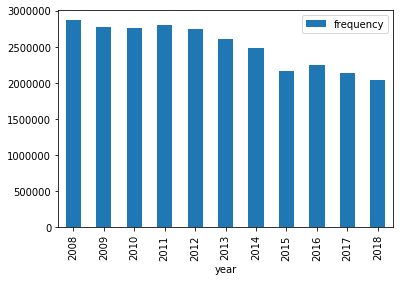

In [13]:
# 3.3.1.a.i - Distribution of infractions by year
print("3.3.1.a.i - Distribution of infractions by year")
infractions_count_per_year.plot(kind='bar',x='year',y='frequency')

3.3.1.a.ii - Distribution of infractions by month


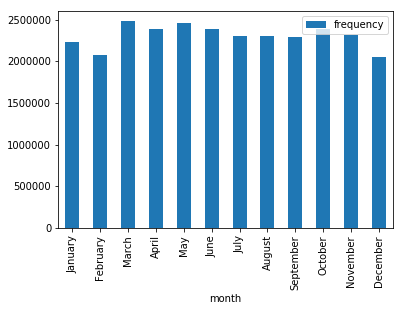

In [14]:
# 3.3.1.a.ii - Distribution of infractions by month
print("3.3.1.a.ii - Distribution of infractions by month")
infractions_count_per_month.plot(kind='bar', x='month', y='frequency')

3.3.1.b - Distribution of top 20 infractions by fines


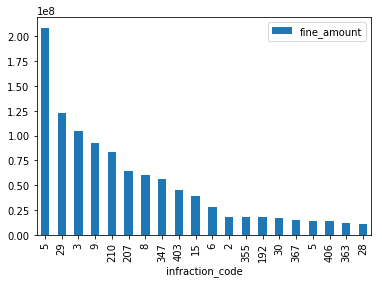

In [15]:
# 3.3.1.b - Distribution of top 20 infractions by fines
print("3.3.1.b - Distribution of top 20 infractions by fines")
df_top_20_infractions_by_revenue.plot(kind='bar', x='infraction_code', y='fine_amount')

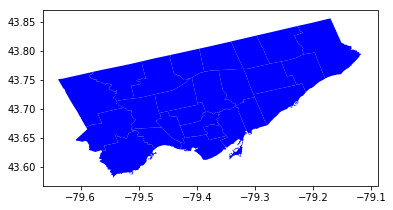

In [16]:
# 3.3.2.a Geographic distribution (location) of top 20 infractions (count)
# 3.3.2.b Geographic distribution by ward for top 20 infractions (count)
# 3.3.2.c Geographic distribution by ward for top 20 infractions (revenue)
# longitude, latitude of infraction is not available, neither there is any mapping provided to convert 
# street address of infractions to the langitude and latitude. Hence was not able to geographically 
# distribute infractions data on the ward map.
wards = gpd.read_file('data/City Wards Data.geojson')
ax = wards.plot(color='blue')
plt.show()